### Base settings

In [1]:
%load_ext autoreload
%autoreload 2

import time
from pprint import pprint
from pathlib import Path
from collections import OrderedDict
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from ood_with_vit.visualizer.feature_extractor import FeatureExtractor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar10.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [4]:
# frequently used variables
model_name = config.model.name
patch_size = config.model.patch_size
summary = config.summary

# log directories
log_root = Path('./logs') / model_name / summary
checkpoint_path = log_root / 'checkpoints'

In [5]:
# initialize ViT model and load pretrained weights
from ood_with_vit.models.vit import ViT

def initialize_vit_model(config, finetuned: bool = True, verbose: int = 0):
    assert config.model.pretrained, 'only pretrained models are allowed'
    if config.model.pretrained:
        if finetuned:
            print('initialize finetuned model...')
            n_class = config.dataset.n_class
            model = torch.hub.load(
                repo_or_dir=config.model.repo,
                model=config.model.pretrained_model,
                pretrained=False,
            )
            model.head = nn.Linear(model.head.in_features, n_class)
        else:
            print('initialize pretrained-only model...')
            model = torch.hub.load(
                repo_or_dir=config.model.repo,
                model=config.model.pretrained_model,
                pretrained=True,
            )
    model = model.to(device=device)
    if verbose:
        print(model)
        
    if finetuned:
        checkpoint = torch.load(checkpoint_path / f'{summary}_best.pt')

        state_dict = checkpoint['model_state_dict']
        trimmed_keys = []
        for key in state_dict.keys():
            # remove prefix 'module.' for each key (in case of DataParallel)
            trimmed_keys.append(key[7:])
        trimmed_state_dict = OrderedDict(list(zip(trimmed_keys, state_dict.values())))

        model.load_state_dict(trimmed_state_dict)
    return model

In [6]:
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader, Dataset

dataset_mean, dataset_std = config.dataset.mean, config.dataset.std
dataset_root = config.dataset.root
img_size = config.model.img_size

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      

id_dataset = CIFAR10(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
id_test_dataloader = DataLoader(
    dataset=id_dataset, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)
id_dataset_name = 'cifar10'

ood_dataset = CIFAR100(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
ood_test_dataloader = DataLoader(
    dataset=ood_dataset, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)
ood_dataset_name = 'cifar100'

print(id_dataset.class_to_idx)
print(ood_dataset.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, '

### Utility

In [7]:
# set seeds
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed = 1234

### OOD detection baselines

In [8]:
from ood_with_vit.utils import compute_ood_scores
from ood_with_vit.utils.ood_metrics import auroc, aupr, fpr_at_95_tpr
from ood_with_vit.utils.visualization import plot_roc_curve, plot_precision_recall_curve

#### OOD detection by MSP (Maximum over Softmax Probability)

In [9]:
from ood_with_vit.metrics.msp import MSP

model = initialize_vit_model(config)
msp = MSP(config, model)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


In [16]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=msp,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


processing out-of-distribution samples...


100%|██████████| 100/100 [00:05<00:00, 17.66it/s]

id mean score: -0.9825615
ood mean score: -0.7670236


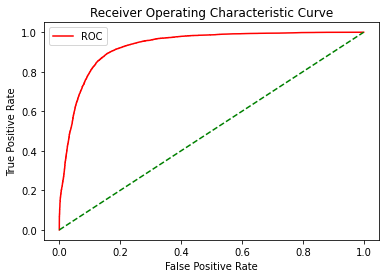

MSP AUROC score: 0.93029612


In [17]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('MSP AUROC score:', auroc_score)

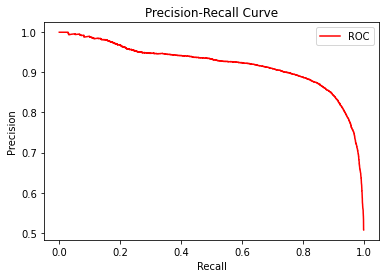

MSP AUPR score: 0.9186822983633804


In [18]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('MSP AUPR score:', aupr_score)

In [19]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('MSP fpr95 score:', fpr95)

MSP fpr95 score: 0.2615


### OOD detection by Mahalanobis

In [62]:
from ood_with_vit.metrics.mahalanobis import Mahalanobis

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar10 = CIFAR10(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
id_train_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config, finetuned=True)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
feature_extractor.hook()
mahalanobis = Mahalanobis(config, model, id_train_dataloader, feature_extractor)

init finetuned model


Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


covariance norm: 23.098447184632178


In [64]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=mahalanobis,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


processing out-of-distribution samples...


100%|██████████| 100/100 [00:07<00:00, 13.32it/s]

id mean score: 182.6435 id variance: 8087.9224
ood mean score: 481.78775 ood variance: 24323.402


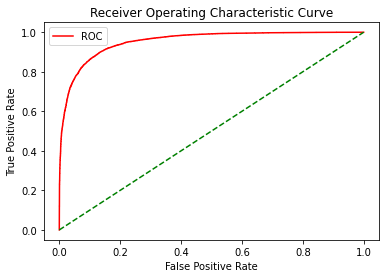

Mahalanobis AUROC score: 0.9535046


In [65]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('Mahalanobis AUROC score:', auroc_score)

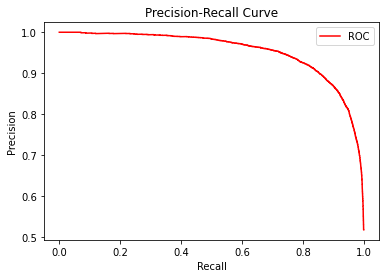

Mahalanobis AUPR score: 0.954139094223694


In [66]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('Mahalanobis AUPR score:', aupr_score)

In [67]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('Mahalanobis fpr95 score:', fpr95)

Mahalanobis fpr95 score: 0.2231


### OOD detection by SML (Standardized Max Logits)

In [9]:
from ood_with_vit.metrics.sml import SML

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar10 = CIFAR10(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
id_train_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config, finetuned=True)
sml = SML(config, model, id_train_dataloader)

init finetuned model


Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:26<00:00,  3.69it/s]


In [10]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=sml,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [00:06<00:00, 15.83it/s]


processing out-of-distribution samples...


100%|██████████| 100/100 [00:06<00:00, 15.49it/s]

id mean score: 0.17674805338695232 id variance: 1.4942061282549082
ood mean score: 3.8848704739479807 ood variance: 3.5674267128303514


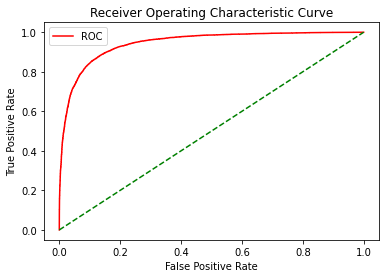

SML AUROC score: 0.944366345


In [11]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('SML AUROC score:', auroc_score)

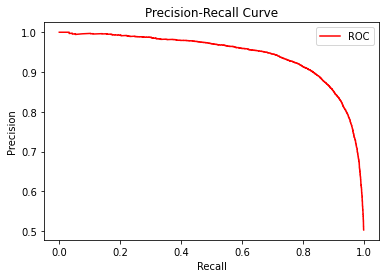

SML AUPR score: 0.9439973436004492


In [12]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('SML AUPR score:', aupr_score)

In [13]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('SML fpr95 score:', fpr95)

SML fpr95 score: 0.2555


### OOD detection by DML

In [11]:
from ood_with_vit.metrics.dml import DML

model = initialize_vit_model(config)
dml = DML(
    config=config, 
    model=model,
)

init finetuned model


Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


name: patch_embed.norm


In [12]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=dml,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


processing out-of-distribution samples...


100%|██████████| 100/100 [01:47<00:00,  1.08s/it]

id mean score: -5.165618972319365 id variance: 4.559320819637561
ood mean score: -1.6254961838081479 ood variance: 5.4545547284633695


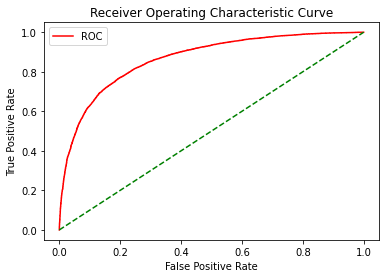

DML AUROC score: 0.865394955


In [13]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('DML AUROC score:', auroc_score)

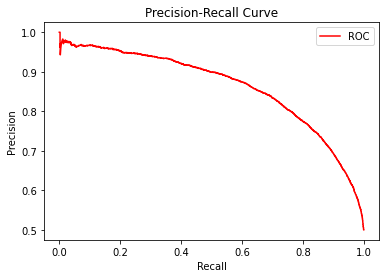

DML AUPR score: 0.8629872217519923


In [14]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('DML AUPR score:', aupr_score)

In [15]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('DML fpr95 score:', fpr95)

DML fpr95 score: 0.5558


### OOD detection by DCL

In [22]:
from ood_with_vit.metrics.dcl import DCL

model = initialize_vit_model(config)
dcl = DCL(
    config=config, 
    model=model,
)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


name: patch_embed.norm


In [23]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=dcl,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


processing out-of-distribution samples...


100%|██████████| 100/100 [02:56<00:00,  1.76s/it]

id mean score: -6.3470625482672824 id variance: 6.36114667583141
ood mean score: -3.259190082673775 ood variance: 6.68506551310177


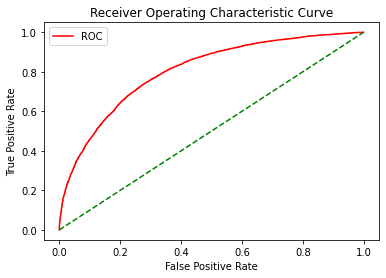

DCL AUROC score: 0.80339931


In [25]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('DCL AUROC score:', auroc_score)

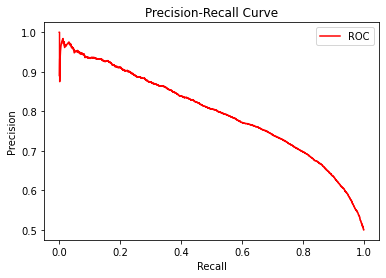

DCL AUPR score: 0.7973135548622043


In [27]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('DCL AUPR score:', aupr_score)

In [28]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('DML fpr95 score:', fpr95)

DML fpr95 score: 0.6705


#### OOD detection by DMD

In [89]:
from ood_with_vit.metrics.dmd import DMD

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar10 = CIFAR10(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
id_train_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
feature_extractor.hook()
dmd = DMD(
    config=config, 
    model=model,
    id_dataloader=id_train_dataloader,
    feature_extractor=feature_extractor,
    mask_method='bottom_ratio',
    mask_ratio=0.6,
    # mask_threshold=1.0,
)

init finetuned model


Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:23<00:00,  4.12it/s]


covariance norm: 23.098447184632178
name: patch_embed.norm


In [90]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=dmd,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


processing out-of-distribution samples...


100%|██████████| 100/100 [01:42<00:00,  1.02s/it]

id mean score: -225.20774670906067 id variance: 13146.344529817845
ood mean score: 38.57276513977051 ood variance: 26759.094493641227


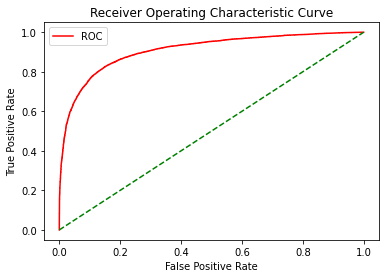

DMD AUROC score: 0.908944265


In [91]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('DMD AUROC score:', auroc_score)

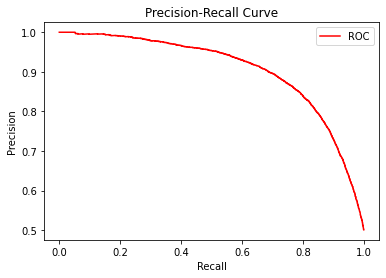

DMD AUPR score: 0.9062466192055976


In [87]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('DMD AUPR score:', aupr_score)

In [88]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('DML fpr95 score:', fpr95)

DML fpr95 score: 0.5365


In [43]:
from ood_with_vit.metrics.dcmd import DCMD

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar10 = CIFAR10(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
id_train_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
feature_extractor.hook()
dcmd = DCMD(
    config=config, 
    model=model,
    id_dataloader=id_train_dataloader,
    feature_extractor=feature_extractor,
)

init finetuned model


Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
  0%|          | 0/98 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7fb48de0e820>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
100%|██████████| 98/98 [00:24<00:00,  3.92it/s]


covariance norm: 23.098447184632178
name: patch_embed.norm


In [32]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=dcmd,
    in_dist_dataloader=id_test_dataloader,
    out_of_dist_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

processing in-distribution samples...


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


processing out-of-distribution samples...


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]

id mean score: -3.8175040916442873 id variance: 4938.416916027109
ood mean score: 65.19537356948852 ood variance: 8738.939114694247


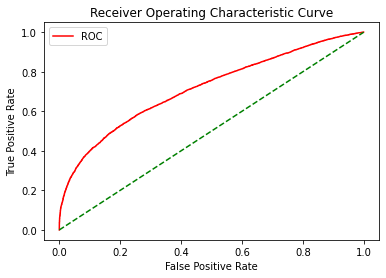

DCL AUROC score: 0.7156381


In [33]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('DCL AUROC score:', auroc_score)

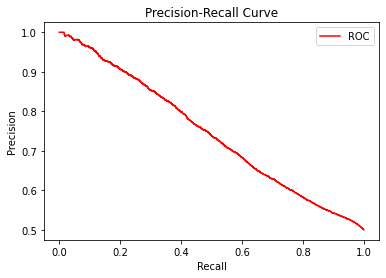

DMD AUPR score: 0.7449869400741642


In [34]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('DMD AUPR score:', aupr_score)

In [35]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('DML fpr95 score:', fpr95)

DML fpr95 score: 0.8522
